In [17]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['axes.facecolor']='white'
matplotlib.rcParams['axes.edgecolor']='black'
matplotlib.rcParams['xtick.color']='black'
matplotlib.rcParams['ytick.color']='black'
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=["black", "#e94cdc", "0.7"])
matplotlib.rcParams['axes.linewidth']=1.3
matplotlib.rcParams['text.color']='black'
from statsmodels.tsa.api import VAR, SVAR
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [18]:
matplotlib.rcParams['figure.figsize'] = (10, 6)

In [19]:
dat = pd.read_excel('/Users/juliashaliapina/Desktop/dz.xlsx')

In [20]:
dat = dat.iloc[:,2:]

gdp - реальный ВВП в ценах 2011 гг. (данные gks), cpi - индекс потребительских цен (gks), usd - реальный прямой курс рубля к доллару (расчет автора на основе валютного курса ММВБ, ИПЦ РФ с Росстата и ИПЦ США из Bureau of labor statistics), m - денежная масса М2 (из данных ЦБ РФ).

Оцениваем реальный ВВП и курс доллара, чтобы избавиться от фактора колебания цен. Кроме того, нам необходимо выявить зависимость этих факторов и инфляции, поэтому нужно оценивать динамику реальных показателей, "очищенных" от уровня цен. ИПЦ традиционно принимается за показатель инфляции.

Для построения модели выбран период 2011-2018 гг., чтобы сравнивать одинаковые отрезки времени. Сравниваются первые и последние 4 года. Данные указаны поквартально для увеличения объема выборки.

В модель включена дополнительная переменная m, отвечающая за объем денежной массы. Согласно количественной теории денег, Mv=PY, то есть существует связь между величиной денежной массы, уровнем цен и выпуском. Так, при росте денежной массы при неизменных выпуске и скорости обращения денег инфляция вырастет. Значит, переменную m необходимо включить в рассмотрение.

In [21]:
dat

,gdp,cpi,usd,m
0,18648.028676,103.808131,28.753422,4930.466667
1,20011.985389,101.144162,28.604420,5023.100000
2,21650.366439,99.710124,30.358413,5280.600000
3,22998.117447,101.345985,31.823309,5438.566667
4,19662.199920,101.456907,30.126624,5774.100000
5,20899.329521,101.729013,30.553223,5797.400000
6,22357.155929,101.888552,31.446456,5986.733333
7,23435.489267,101.345892,30.585727,5958.633333
8,19909.315335,101.880652,30.011504,6216.633333
9,21251.172958,101.598294,31.191434,6294.566667


In [22]:
dat.head()

,gdp,cpi,usd,m
0,18648.028676,103.808131,28.753422,4930.466667
1,20011.985389,101.144162,28.604420,5023.100000
2,21650.366439,99.710124,30.358413,5280.600000
3,22998.117447,101.345985,31.823309,5438.566667
4,19662.199920,101.456907,30.126624,5774.100000


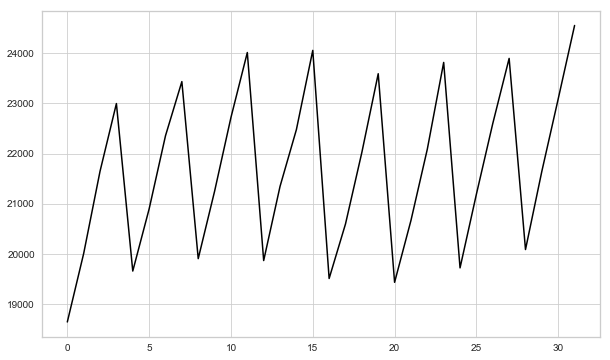

In [23]:
dat['gdp'].plot()

Избавимся от сезонности

In [24]:
import statsmodels.tsa as sts

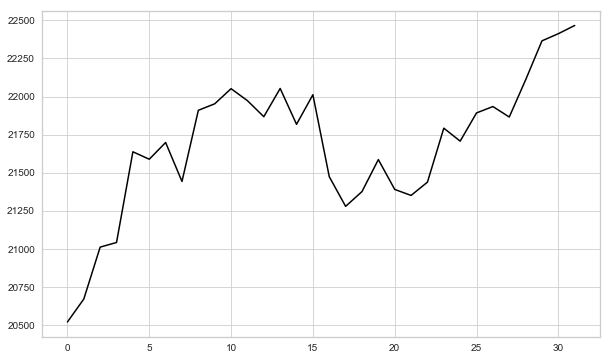

In [25]:
(dat['gdp']/sts.seasonal.seasonal_decompose(dat['gdp'], model='multiplicative', freq=4).seasonal).plot()

In [26]:
dat['gdp'] = dat['gdp']/sts.seasonal.seasonal_decompose(dat['gdp'], model='multiplicative', freq=4).seasonal

Оцениваем ранг коинтеграции

In [27]:
res1=sts.vector_ar.vecm.coint_johansen(dat, det_order=0, k_ar_diff=4)

In [28]:
res1.lr2

array([56.86004268, 34.78834507,  8.36091946,  2.95931384])

In [29]:
res1.cvm

array([[25.1236, 27.5858, 32.7172],
       [18.8928, 21.1314, 25.865 ],
       [12.2971, 14.2639, 18.52  ],
       [ 2.7055,  3.8415,  6.6349]])

In [30]:
res1.eig

array([0.87826729, 0.72430421, 0.26630633, 0.10381124])

Ряды коинтегрированы с рангом 2

Оциниваем VAR

In [31]:
model = VAR(dat).fit(4)
print(model.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 06, Jun, 2019
Time:                     23:54:47
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    25.8535
Nobs:                     28.0000    HQIC:                   23.6072
Log likelihood:          -407.575    FPE:                1.44806e+10
AIC:                      22.6181    Det(Omega_mle):     2.17054e+09
--------------------------------------------------------------------
Results for equation gdp
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const      26101.375126     11467.439156            2.276           0.023
L1.gdp         0.008984         0.238078            0.038           0.970
L1.cpi       -23.267106        41.127551           -0.566           0.572
L1.usd       -34

Строим графики функций импульсного отклика для всех переменных

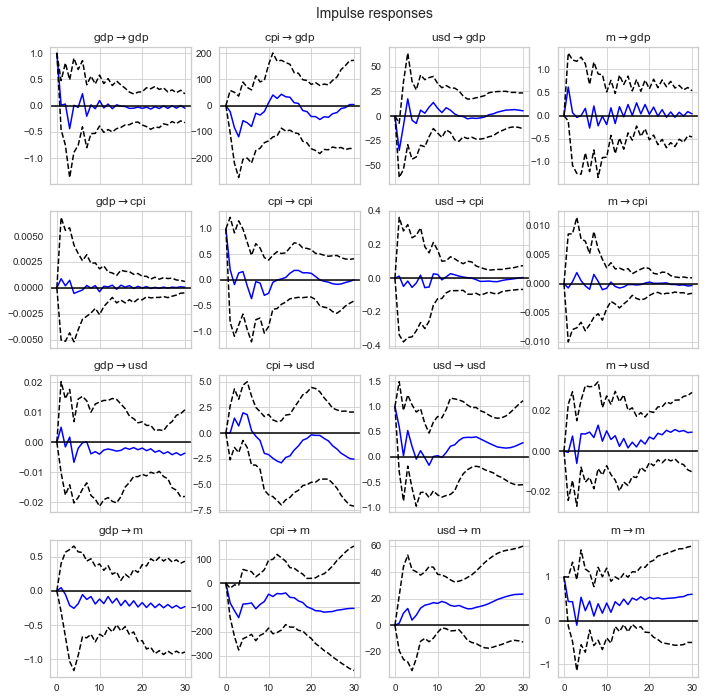

In [32]:
model.irf(30).plot();

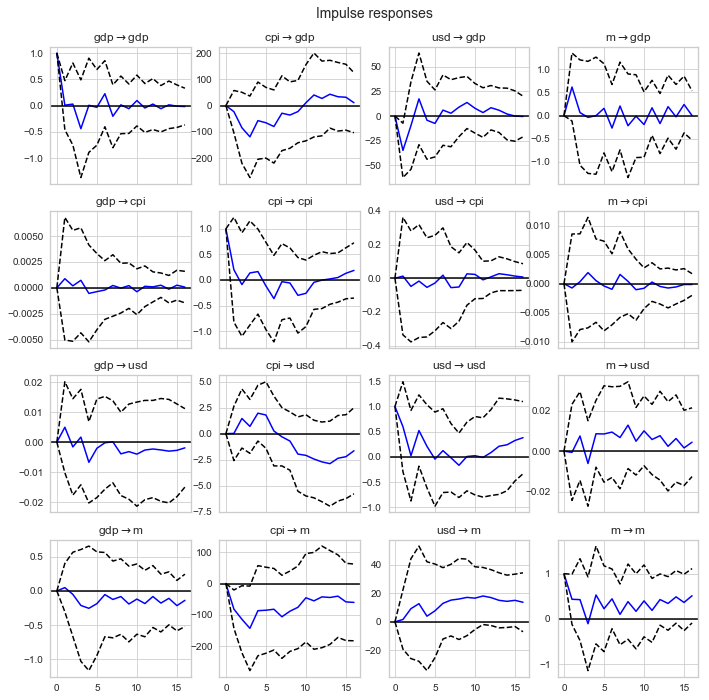

In [33]:
model.irf(16).plot();

In [34]:
A = np.asarray([[1, 'E', 'E',0],['E', 1, 'E','E'],[0, 'E', 1, 0],[0, 0, 0,1]])
B = np.asarray([['E', 0, 0,0], [0, 'E', 0,0], [0, 0, 'E',0], [0, 0,0, 'E']])

Строим графики импульсного отклика для svar

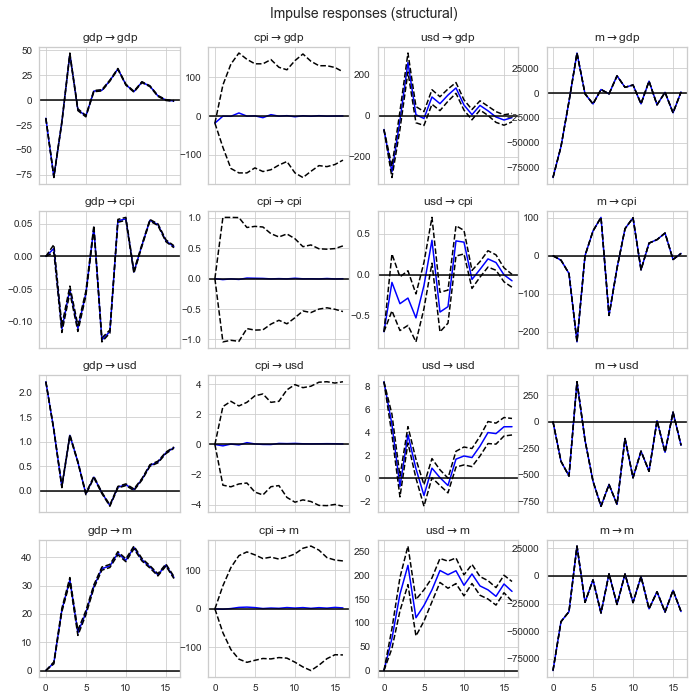

In [35]:
model = SVAR(dat, svar_type='AB', A=A, B=B).fit(maxlags=4)
model.irf(16).plot();

In [36]:
print(model.summary())

  Summary of Regression Results   
Model:                        SVAR
Method:                        OLS
Date:           Thu, 06, Jun, 2019
Time:                     23:54:53
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    25.8535
Nobs:                     28.0000    HQIC:                   23.6072
Log likelihood:          -407.575    FPE:                1.44806e+10
AIC:                      22.6181    Det(Omega_mle):     2.17054e+09
--------------------------------------------------------------------
Results for equation gdp
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const      26101.375126     11467.439156            2.276           0.023
L1.gdp         0.008984         0.238078            0.038           0.970
L1.cpi       -23.267106        41.127551           -0.566           0.572
L1.usd       -34

Оцениваем с 2 лагами

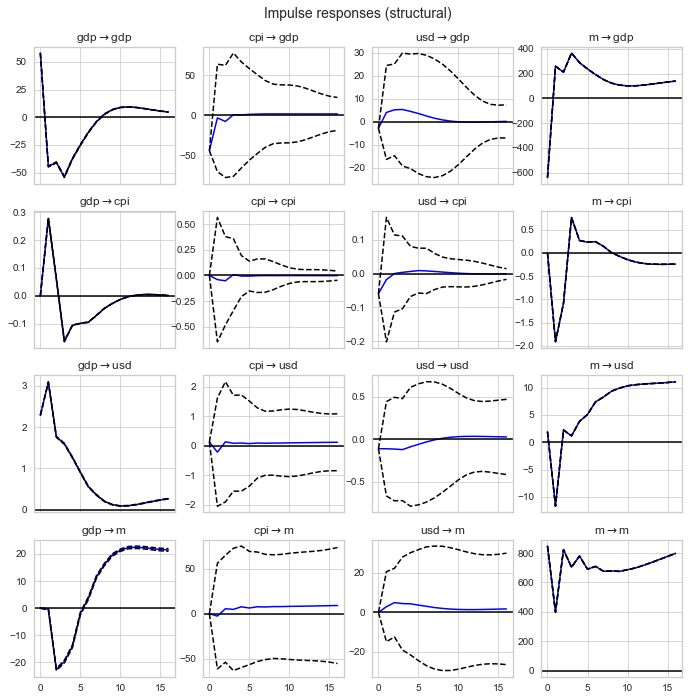

In [37]:
model = SVAR(dat, svar_type='AB', A=A, B=B).fit(maxlags=2)
model.irf(16).plot();

In [38]:
print(model.summary())

  Summary of Regression Results   
Model:                        SVAR
Method:                        OLS
Date:           Thu, 06, Jun, 2019
Time:                     23:54:54
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    25.0113
Nobs:                     30.0000    HQIC:                   23.8677
Log likelihood:          -484.220    FPE:                1.46246e+10
AIC:                      23.3298    Det(Omega_mle):     5.12048e+09
--------------------------------------------------------------------
Results for equation gdp
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const      21697.708453      4960.986373            4.374           0.000
L1.gdp         0.017058         0.202328            0.084           0.933
L1.cpi       -32.410236        34.301651           -0.945           0.345
L1.usd       -19

Оцениваем модель для первых 4 лет: с 2011 по 2014 гг.

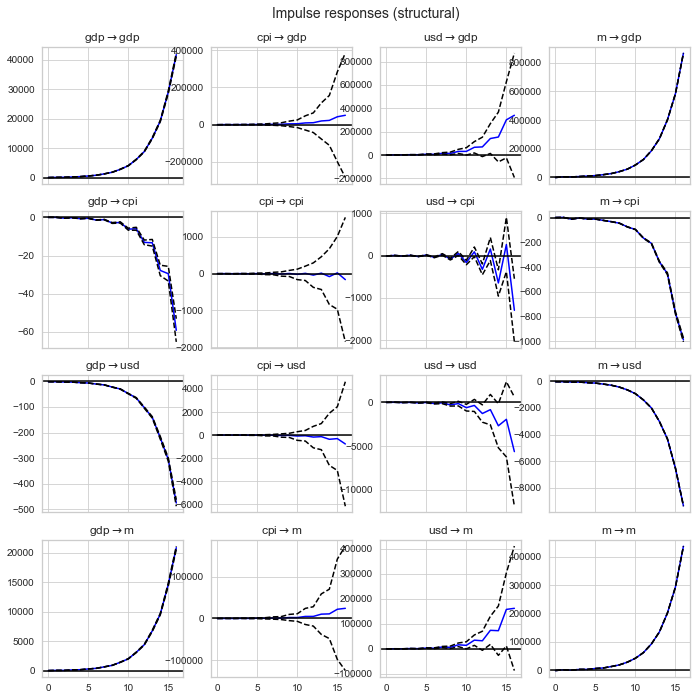

In [39]:
model = SVAR(dat.iloc[:16,:], svar_type='AB', A=A, B=B).fit(maxlags=2)
model.irf(16).plot();

In [40]:
print(model.summary())

  Summary of Regression Results   
Model:                        SVAR
Method:                        OLS
Date:           Thu, 06, Jun, 2019
Time:                     23:54:56
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    18.8790
Nobs:                     14.0000    HQIC:                   17.0836
Log likelihood:          -164.111    FPE:                7.99636e+07
AIC:                      17.2357    Det(Omega_mle):     1.09772e+07
--------------------------------------------------------------------
Results for equation gdp
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const      33512.100396     20125.991714            1.665           0.096
L1.gdp        -0.636775         0.489290           -1.301           0.193
L1.cpi        56.687575       109.183965            0.519           0.604
L1.usd      -130

Оцениваем модель для оставшихся 4 лет: с 2015 по 2018 гг.

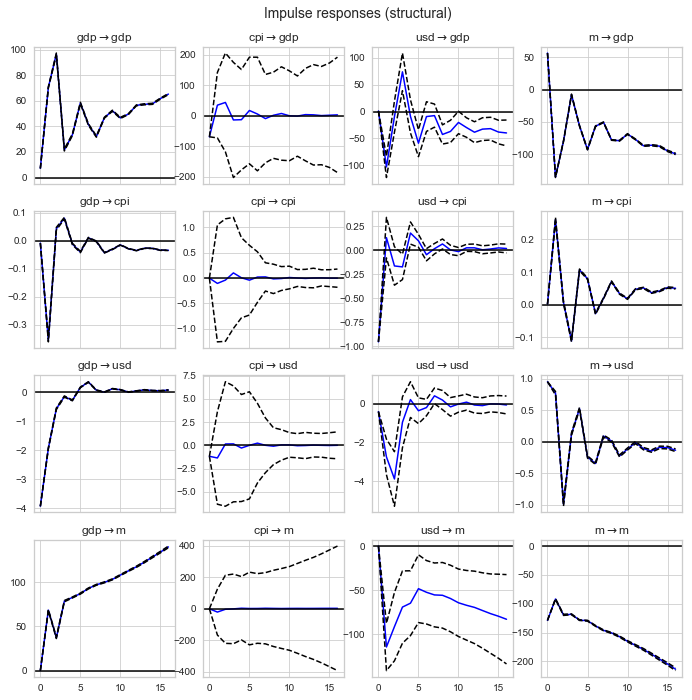

In [41]:
model = SVAR(dat.iloc[16:,:], svar_type='AB', A=A, B=B).fit(maxlags=2)
model.irf(16).plot();

In [42]:
print(model.summary())

  Summary of Regression Results   
Model:                        SVAR
Method:                        OLS
Date:           Thu, 06, Jun, 2019
Time:                     23:54:58
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    21.2107
Nobs:                     14.0000    HQIC:                   19.4153
Log likelihood:          -180.432    FPE:                8.23258e+08
AIC:                      19.5674    Det(Omega_mle):     1.13015e+08
--------------------------------------------------------------------
Results for equation gdp
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const      20427.904411      6621.879868            3.085           0.002
L1.gdp        -0.180160         0.267614           -0.673           0.501
L1.cpi       115.554658        54.704498            2.112           0.035
L1.usd       -18

Во втором периоде влияние более существенно. Вероятно, это связано с тем, что в последние 4 года шоки были более ощутимы ввиду экономико-политических событий таких, как санкции.